In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

True
2
NVIDIA GeForce GTX 1080 Ti


In [2]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch.nn.functional as F

In [3]:
transform_all = T.Compose([
    T.Resize((224, 224)),   # paksa seragam
    T.ToTensor(),
])

In [4]:
data_root = "data"   # Ubah sesuai directory Anda
full_dataset = ImageFolder(data_root, transform=transform_all)
num_classes = len(full_dataset.classes)

# split dataset otomatis
train_size = int(0.7 * len(full_dataset))
val_size   = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

In [5]:
class ResNetBottleneck(nn.Module):
    def __init__(self, in_channels, filters):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, filters, 1)
        self.bn1 = nn.BatchNorm2d(filters)

        self.conv2 = nn.Conv2d(filters, filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(filters)

        self.conv3 = nn.Conv2d(filters, filters * 4, 1)
        self.bn3 = nn.BatchNorm2d(filters * 4)

        self.shortcut_needed = (in_channels != filters * 4)
        if self.shortcut_needed:
            self.shortcut_conv = nn.Conv2d(in_channels, filters * 4, 1)

    def forward(self, x):
        shortcut = x
        if self.shortcut_needed:
            shortcut = self.shortcut_conv(x)

        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        return torch.relu(x + shortcut)


class HybridEfficientNet(nn.Module):
    def __init__(self, num_classes=4, dropoout=0.3):
        super().__init__()

        # Load pretrained EfficientNet-B0
        self.base = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        # Freeze feature extractor
        self.base.features.requires_grad_(False)

        #in_channels = 1280  # output EfficientNetB0 channels
        in_channels = self.base.features[-1].out_channels

        self.b1 = ResNetBottleneck(in_channels, 64)
        self.b2 = ResNetBottleneck(64 * 4, 64)

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropoout)
        self.fc = nn.Linear(64 * 4, num_classes)

    def forward(self, x):
        x = self.base.features(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

class HybridMobileNet(nn.Module):
    def __init__(self, num_classes=4, dropout=0.3):
        super().__init__()

        self.base = models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )

        self.base.features.requires_grad_(False)

        # ambil channel output terakhir
        in_channels = self.base.features[-1].out_channels  # = 576

        self.b1 = ResNetBottleneck(in_channels, 64)   # 576 → 256
        self.b2 = ResNetBottleneck(64 * 4, 64)        # 256 → 256

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64 * 4, num_classes)      # 256 → num_classes

    def forward(self, x):
        x = self.base.features(x)
        x = self.b1(x)
        x = self.b2(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        return self.fc(x)

In [7]:
def build_vgg16_pretrained(num_classes):
    model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

def build_vgg16_scratch(num_classes):
    model = models.vgg16(weights=None)
    model.classifier[6] = nn.Linear(4096, num_classes)
    return model

def build_efficientnet_pretrained(version, num_classes):
    version = version.lower()
    weights_dict = {
        "b0": models.EfficientNet_B0_Weights.IMAGENET1K_V1,
        "b1": models.EfficientNet_B1_Weights.IMAGENET1K_V1,
        "b2": models.EfficientNet_B2_Weights.IMAGENET1K_V1,
        "b3": models.EfficientNet_B3_Weights.IMAGENET1K_V1,
        "b4": models.EfficientNet_B4_Weights.IMAGENET1K_V1,
        "b5": models.EfficientNet_B5_Weights.IMAGENET1K_V1,
        "b6": models.EfficientNet_B6_Weights.IMAGENET1K_V1,
        "b7": models.EfficientNet_B7_Weights.IMAGENET1K_V1
    }

    if version not in weights_dict:
        raise ValueError("version harus salah satu dari: b0–b7")

    model_fn = getattr(models, f"efficientnet_{version}")
    model = model_fn(weights=weights_dict[version])

    # Ganti classifier
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


def build_efficientnet_scratch(version, num_classes):
    version = version.lower()
    model_fn = getattr(models, f"efficientnet_{version}")
    model = model_fn(weights=None)

    # Ganti classifier
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)

    return model


def build_mobilenetv3_pretrained(size, num_classes):
    size = size.lower()

    if size == "small":
        model = models.mobilenet_v3_small(
            weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1
        )
    elif size == "large":
        model = models.mobilenet_v3_large(
            weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V1
        )
    else:
        raise ValueError("size harus 'small' atau 'large'")

    # Ganti classifier final
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

    return model


def build_mobilenetv3_scratch(size, num_classes):
    size = size.lower()
    if size == "small":
        model = models.mobilenet_v3_small(weights=None)
    elif size == "large":
        model = models.mobilenet_v3_large(weights=None)
    else:
        raise ValueError("size harus 'small' atau 'large'")

    in_features = model.classifier[-1].in_features
    model.classifier[-1] = nn.Linear(in_features, num_classes)

    return model

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Build models
model_vgg16pre = build_vgg16_pretrained(num_classes)
model_vgg16 = build_vgg16_scratch(num_classes)
model_effNetB0pre = build_efficientnet_pretrained("b0", num_classes)
model_effNetB1pre = build_efficientnet_pretrained("b1", num_classes)
model_effNetB2pre = build_efficientnet_pretrained("b2", num_classes)
model_effNetB3pre = build_efficientnet_pretrained("b3", num_classes)
model_effNetB4pre = build_efficientnet_pretrained("b4", num_classes)
model_effNetB5pre = build_efficientnet_pretrained("b5", num_classes)
model_effNetB6pre = build_efficientnet_pretrained("b6", num_classes)
model_effNetB7pre = build_efficientnet_pretrained("b7", num_classes)
model_effNetB0 = build_efficientnet_scratch("b0", num_classes)
model_effNetB1 = build_efficientnet_scratch("b1", num_classes)
model_effNetB2 = build_efficientnet_scratch("b2", num_classes)
model_effNetB3 = build_efficientnet_scratch("b3", num_classes)
model_effNetB4 = build_efficientnet_scratch("b4", num_classes)
model_effNetB5 = build_efficientnet_scratch("b5", num_classes)
model_effNetB6 = build_efficientnet_scratch("b6", num_classes)
model_effNetB7 = build_efficientnet_scratch("b7", num_classes)

# MobileNetV3 Small pretrained
model_mobnetv3_small_pre = build_mobilenetv3_pretrained("small", num_classes)
model_mobnetv3_large_pre = build_mobilenetv3_pretrained("large", num_classes)

# MobileNetV3 Large scratch
model_mobnetv3_small = build_mobilenetv3_scratch("small", num_classes)
model_mobnetv3_large = build_mobilenetv3_scratch("large", num_classes)

# custom
model_hybrideffnet =  HybridEfficientNet(num_classes=4)
#model_hybridmobnet =  HybridMobileNet(num_classes=4)
model_hybridmobnet = HybridMobileNet(num_classes=4)

In [10]:
model_vgg16pre = model_vgg16pre.to(device)
model_vgg16 = model_vgg16.to(device)
model_effNetB0pre = model_effNetB0pre.to(device)
model_effNetB1pre = model_effNetB1pre.to(device)
model_effNetB2pre = model_effNetB2pre.to(device)
model_effNetB3pre = model_effNetB3pre.to(device)
model_effNetB4pre = model_effNetB4pre.to(device)
model_effNetB5pre = model_effNetB5pre.to(device)
model_effNetB6pre = model_effNetB6pre.to(device)
model_effNetB7pre = model_effNetB7pre.to(device)
model_effNetB0 = model_effNetB0.to(device)
model_effNetB1 = model_effNetB1.to(device)
model_effNetB2 = model_effNetB2.to(device)
model_effNetB3 = model_effNetB3.to(device)
model_effNetB4 = model_effNetB4.to(device)
model_effNetB5 = model_effNetB5.to(device)
model_effNetB6 = model_effNetB6.to(device)
model_effNetB7 = model_effNetB7.to(device)

model_mobnetv3_small_pre = model_mobnetv3_small_pre.to(device)
model_mobnetv3_large_pre = model_mobnetv3_large_pre.to(device)

# MobileNetV3 Large scratch
model_mobnetv3_small = model_mobnetv3_small.to(device)
model_mobnetv3_large = model_mobnetv3_large.to(device)

model_hybrideffnet = model_hybrideffnet.to(device)
model_hybridmobnet = model_hybridmobnet.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()

optimizer_vgg16pre = torch.optim.Adam(model_vgg16pre.parameters(), lr=1e-4)
optimizer_vgg16 = torch.optim.Adam(model_vgg16.parameters(), lr=1e-4)
optimizer_effNetB0pre = torch.optim.Adam(model_effNetB0pre.parameters(), lr=1e-4)
optimizer_effNetB1pre = torch.optim.Adam(model_effNetB1pre.parameters(), lr=1e-4)
optimizer_effNetB2pre = torch.optim.Adam(model_effNetB2pre.parameters(), lr=1e-4)
optimizer_effNetB3pre = torch.optim.Adam(model_effNetB3pre.parameters(), lr=1e-4)
optimizer_effNetB4pre = torch.optim.Adam(model_effNetB4pre.parameters(), lr=1e-4)
optimizer_effNetB5pre = torch.optim.Adam(model_effNetB5pre.parameters(), lr=1e-4)
optimizer_effNetB6pre = torch.optim.Adam(model_effNetB6pre.parameters(), lr=1e-4)
optimizer_effNetB7pre = torch.optim.Adam(model_effNetB7pre.parameters(), lr=1e-4)
optimizer_effNetB0 = torch.optim.Adam(model_effNetB0.parameters(), lr=1e-4)
optimizer_effNetB1 = torch.optim.Adam(model_effNetB1.parameters(), lr=1e-4)
optimizer_effNetB2 = torch.optim.Adam(model_effNetB2.parameters(), lr=1e-4)
optimizer_effNetB3 = torch.optim.Adam(model_effNetB3.parameters(), lr=1e-4)
optimizer_effNetB4 = torch.optim.Adam(model_effNetB4.parameters(), lr=1e-4)
optimizer_effNetB5 = torch.optim.Adam(model_effNetB5.parameters(), lr=1e-4)
optimizer_effNetB6 = torch.optim.Adam(model_effNetB6.parameters(), lr=1e-4)
optimizer_effNetB7 = torch.optim.Adam(model_effNetB7.parameters(), lr=1e-4)

optimizer_mobnetv3_small_pre = torch.optim.Adam(model_mobnetv3_small_pre.parameters(), lr=1e-4)
optimizer_mobnetv3_large_pre = torch.optim.Adam(model_mobnetv3_large_pre.parameters(), lr=1e-4)
optimizer_mobnetv3_small = torch.optim.Adam(model_mobnetv3_small.parameters(), lr=1e-4)
optimizer_mobnetv3_large = torch.optim.Adam(model_mobnetv3_small.parameters(), lr=1e-4)

#optimizer_hybrideffnet = torch.optim.Adam(model_hybrideffnet.parameters(), lr=1e-4)
#optimizer_hybridmobnet = torch.optim.Adam(model_hybridmobnet.parameters(), lr=1e-4)

optimizer_hybrideffnet = torch.optim.AdamW(
    model_hybrideffnet.parameters(), lr=1e-4, weight_decay=1e-4
)

optimizer_hybridmobnet = torch.optim.AdamW(
    model_hybridmobnet.parameters(), lr=1e-4, weight_decay=1e-4
)



In [13]:
def train_model(model, optimizer, name="model", scheduler=False, epochs=10):

    scheduler_optimizer = None
    if scheduler:
        scheduler_optimizer = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs
        )
    
    start_time = time.perf_counter()

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0
        correct = 0
        total = 0

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(correct / total)

        model.eval()
        val_running_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)

                loss = criterion(outputs, labels)
                val_running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accs.append(correct / total)

        if scheduler_optimizer is not None:
            scheduler_optimizer.step() 

        print(f"[{name}] Epoch {epoch+1}/{epochs}")
        print(f"  Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")
        print(f"  Train Acc : {train_accs[-1]:.4f} | Val Acc : {val_accs[-1]:.4f}")

        clear_output(wait=True)

        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        # Loss panel
        ax[0].plot(train_losses, label="Train Loss")
        ax[0].plot(val_losses, label="Val Loss")
        ax[0].set_title("Training & Validation Loss")
        ax[0].legend()

        # Acc panel
        ax[1].plot(train_accs, label="Train Acc")
        ax[1].plot(val_accs, label="Val Acc")
        ax[1].set_title("Training & Validation Accuracy")
        ax[1].legend()

        plt.tight_layout()
        display(fig)
        plt.close(fig)

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    return train_losses, val_losses, train_accs, val_accs, elapsed_time

def Summary(name, epoch, train_losses, val_losses, train_accs, val_accs, elapsed_time):
    print()
    print(f"[{name}]")
    print(f"  Total Epochs: {epoch}")
    print(f"  Train Loss: {np.average(train_losses):.4f} | Val Loss: {np.average(val_losses):.4f}")
    print(f"  Train Acc : {train_accs[-1]:.4f} | Val Acc : {val_accs[-1]:.4f}")
    print(f"  Time : {elapsed_time:.4f}s ~ {(elapsed_time / 60):.4f}m")

from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import torch

import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, class_names, figsize=(8,6)):
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Label angka di kotak
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="black" if cm[i, j] > thresh else "white")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

def classification_report_df(y_true, y_pred, class_names):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    df = pd.DataFrame(report).transpose()
    return df

def evaluate_model(model, dataloader, device, class_names):
    start_time = time.perf_counter()
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    cm = confusion_matrix(all_labels, all_preds)

    return {
        "confusion_matrix": cm,
        "preds": all_preds,
        "labels": all_labels,
        "time": elapsed_time
    }

def clean_gpu():
    for var in list(globals().keys()):
        if isinstance(globals()[var], torch.Tensor):
            del globals()[var]

    import gc
    gc.collect()
    torch.cuda.synchronize()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    

In [14]:
def pipeline(name, model, optimizer, loader, epochs=10, scheduler=None):
    train_losses, val_losses, train_accs, val_accs, elapsed_time = train_model(model, optimizer, name=name, scheduler=scheduler, epochs=epochs)
    Summary(name, epochs, train_losses, val_losses, train_accs, val_accs, elapsed_time)
    results = evaluate_model(model, loader, device, full_dataset.classes)
    plot_confusion_matrix(results["confusion_matrix"], full_dataset.classes)
    df_report = classification_report_df(results["labels"], results["preds"], full_dataset.classes)
    display(df_report)
    torch.save(model.state_dict(), name + ".pth")
    del model
    del optimizer
    clean_gpu()

In [25]:
epochs = 10

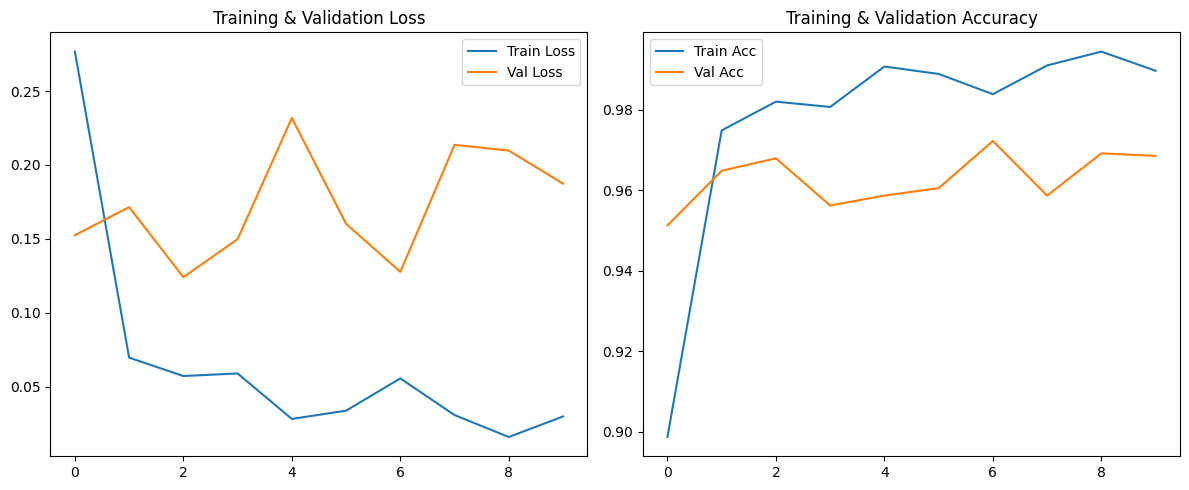


[VGG16 Pretrained]
  Total Epochs: 10
  Train Loss: 0.0656 | Val Loss: 0.1728
  Train Acc : 0.9897 | Val Acc : 0.9685
  Time : 434.8949s ~ 7.2482m


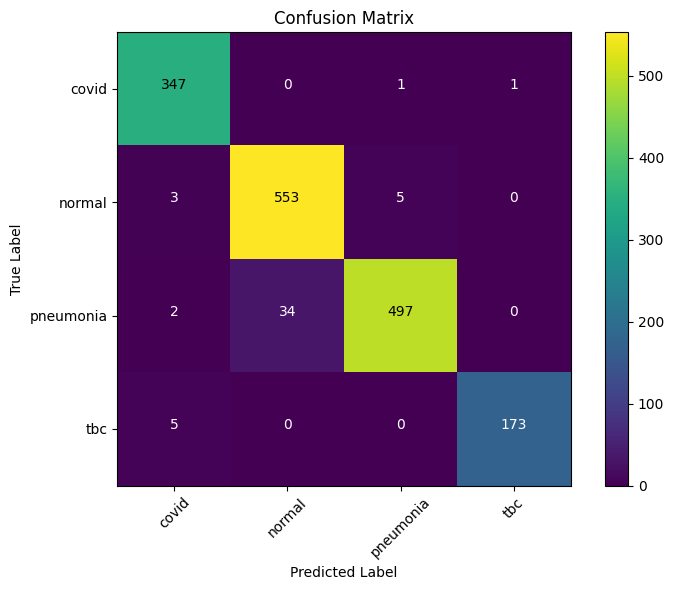

,precision,recall,f1-score,support
covid,0.971989,0.994269,0.983003,349.000000
normal,0.942078,0.985740,0.963415,561.000000
pneumonia,0.988072,0.932458,0.959459,533.000000
tbc,0.994253,0.971910,0.982955,178.000000
accuracy,0.968538,0.968538,0.968538,0.968538
macro avg,0.974098,0.971094,0.972208,1621.000000
weighted avg,0.969370,0.968538,0.968477,1621.000000


In [18]:
pipeline("VGG16 Pretrained", epochs, model_vgg16pre, optimizer_vgg16pre, val_loader)

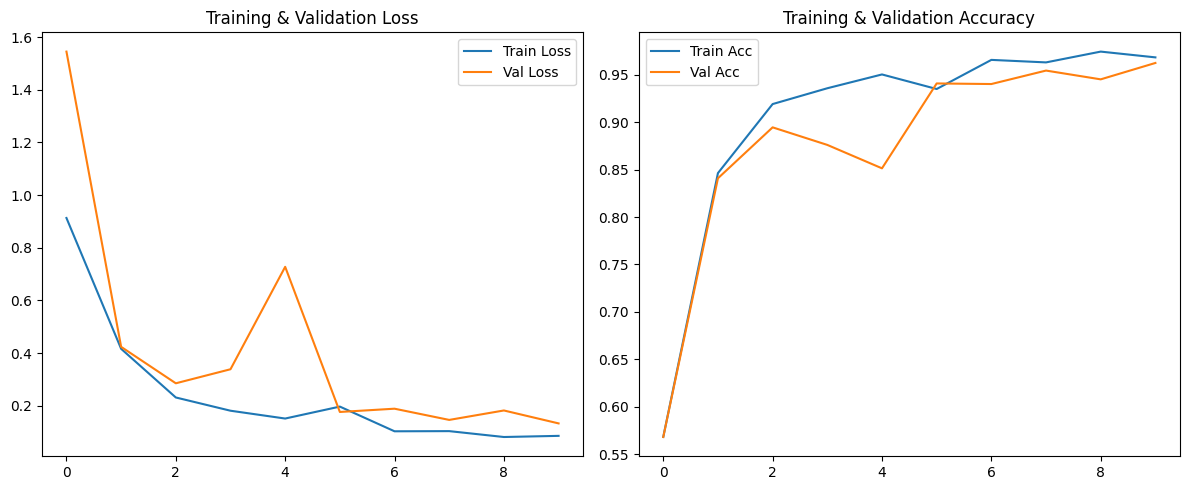


[VGG16]
  Total Epochs: 10
  Train Loss: 0.2467 | Val Loss: 0.4149
  Train Acc : 0.9683 | Val Acc : 0.9624
  Time : 424.2921s ~ 7.0715m


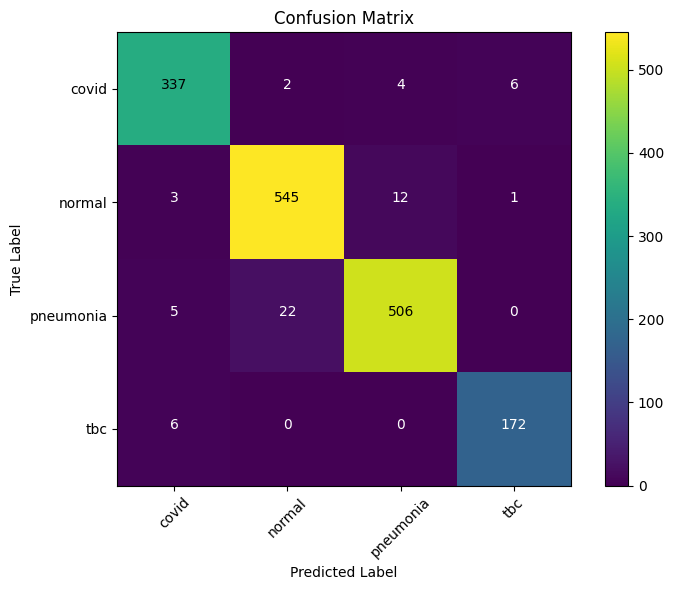

,precision,recall,f1-score,support
covid,0.960114,0.965616,0.962857,349.000000
normal,0.957821,0.971480,0.964602,561.000000
pneumonia,0.969349,0.949343,0.959242,533.000000
tbc,0.960894,0.966292,0.963585,178.000000
accuracy,0.962369,0.962369,0.962369,0.962369
macro avg,0.962044,0.963183,0.962572,1621.000000
weighted avg,0.962442,0.962369,0.962352,1621.000000


In [19]:
pipeline("VGG16", epochs, model_vgg16, optimizer_vgg16, val_loader)

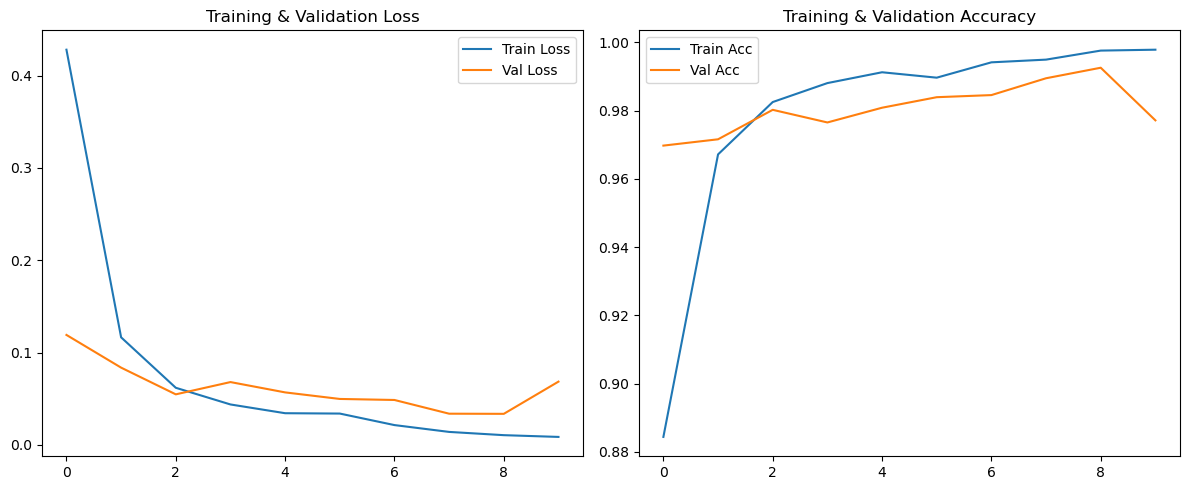


[EfficientNet B0 Pretrained]
  Total Epochs: 10
  Train Loss: 0.0773 | Val Loss: 0.0617
  Train Acc : 0.9979 | Val Acc : 0.9772
  Time : 239.9138s ~ 3.9986m


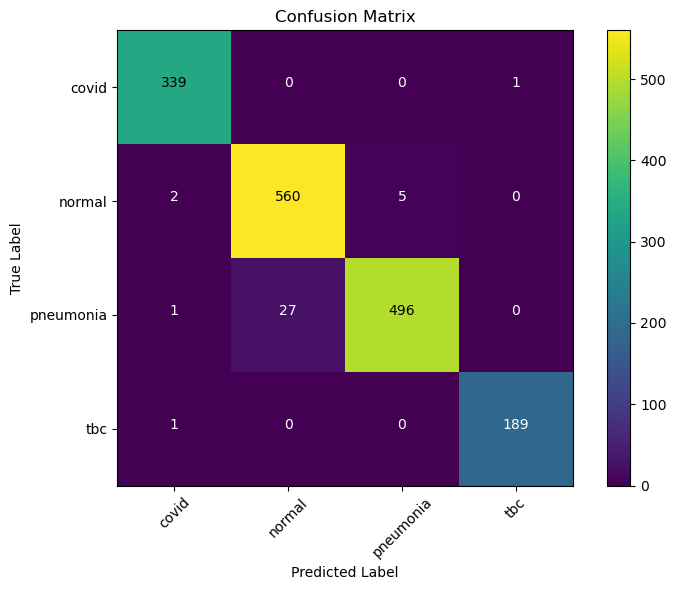

,precision,recall,f1-score,support
covid,0.988338,0.997059,0.992679,340.000000
normal,0.954003,0.987654,0.970537,567.000000
pneumonia,0.990020,0.946565,0.967805,524.000000
tbc,0.994737,0.994737,0.994737,190.000000
accuracy,0.977175,0.977175,0.977175,0.977175
macro avg,0.981775,0.981504,0.981440,1621.000000
weighted avg,0.977622,0.977175,0.977135,1621.000000


In [75]:
pipeline("EfficientNet B0 Pretrained", epochs, model_effNetB0pre, optimizer_effNetB0pre, val_loader)

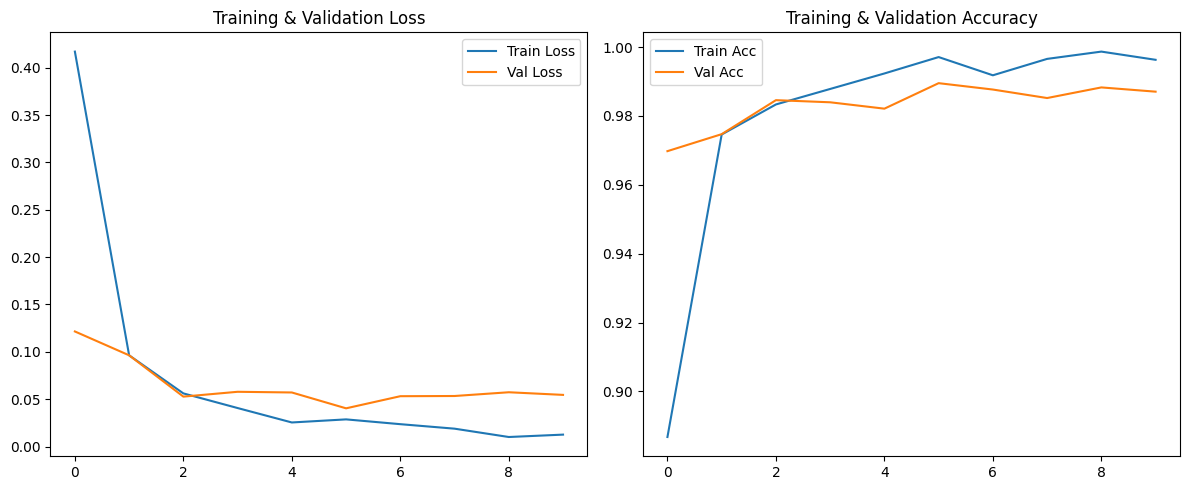


[EfficientNet B1 Pretrained]
  Total Epochs: 10
  Train Loss: 0.0729 | Val Loss: 0.0644
  Train Acc : 0.9963 | Val Acc : 0.9870
  Time : 307.6396s ~ 5.1273m


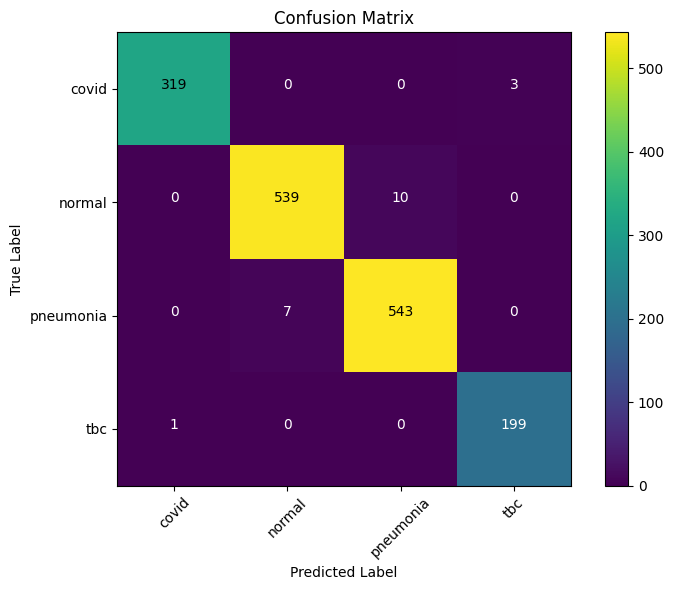

,precision,recall,f1-score,support
covid,0.996875,0.990683,0.993769,322.000000
normal,0.987179,0.981785,0.984475,549.000000
pneumonia,0.981917,0.987273,0.984587,550.000000
tbc,0.985149,0.995000,0.990050,200.000000
accuracy,0.987045,0.987045,0.987045,0.987045
macro avg,0.987780,0.988685,0.988220,1621.000000
weighted avg,0.987069,0.987045,0.987047,1621.000000


In [22]:
pipeline("EfficientNet B1 Pretrained", epochs, model_effNetB1pre, optimizer_effNetB1pre, val_loader)

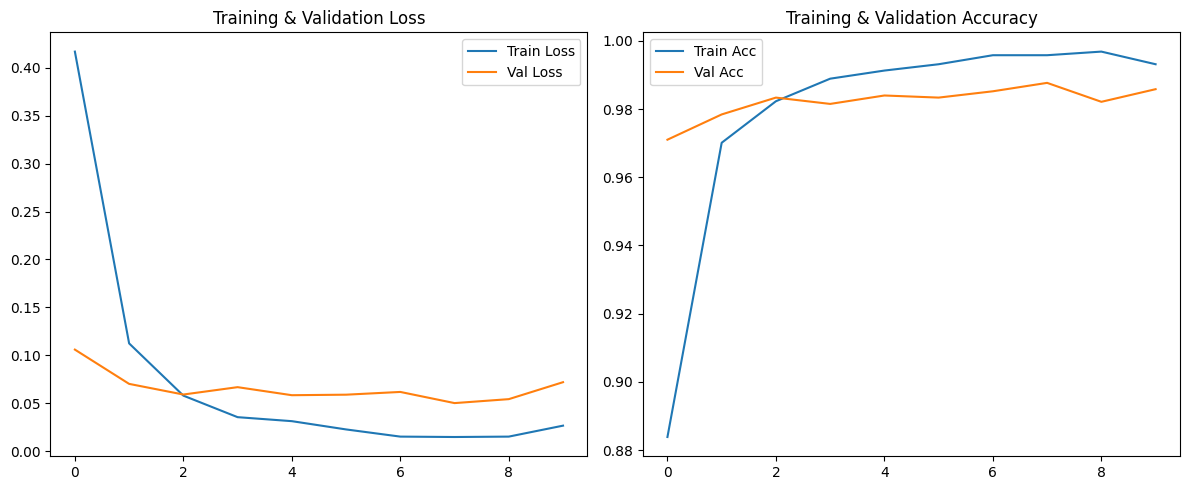


[EfficientNet B2 Pretrained]
  Total Epochs: 10
  Train Loss: 0.0749 | Val Loss: 0.0658
  Train Acc : 0.9931 | Val Acc : 0.9858
  Time : 314.7669s ~ 5.2461m


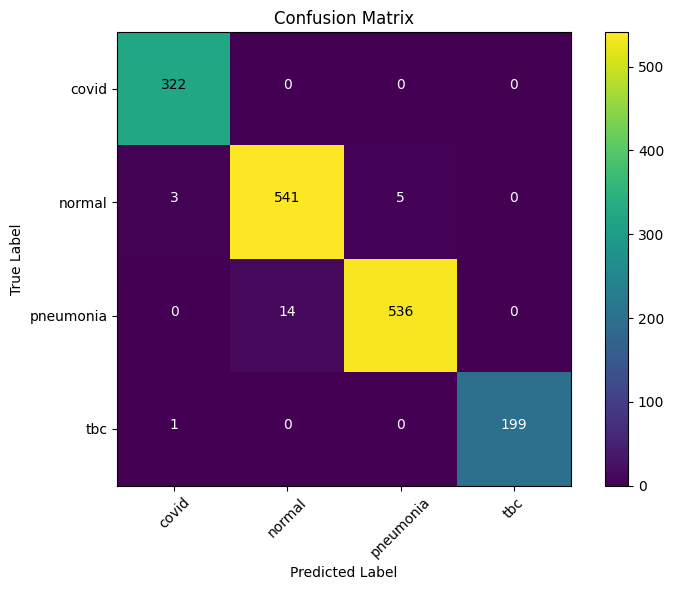

,precision,recall,f1-score,support
covid,0.987730,1.000000,0.993827,322.000000
normal,0.974775,0.985428,0.980072,549.000000
pneumonia,0.990758,0.974545,0.982585,550.000000
tbc,1.000000,0.995000,0.997494,200.000000
accuracy,0.985811,0.985811,0.985811,0.985811
macro avg,0.988316,0.988743,0.988495,1621.000000
weighted avg,0.985884,0.985811,0.985807,1621.000000


In [27]:
pipeline("EfficientNet B2 Pretrained", epochs, model_effNetB2pre, optimizer_effNetB2pre, val_loader)

In [ ]:
pipeline("EfficientNet B3 Pretrained", epochs, model_effNetB3pre, optimizer_effNetB3pre, val_loader)

In [ ]:
pipeline("EfficientNet B4 Pretrained", epochs, model_effNetB4pre, optimizer_effNetB4pre, val_loader)

In [ ]:
pipeline("EfficientNet B5 Pretrained", epochs, model_effNetB5pre, optimizer_effNetB5pre, val_loader)

In [ ]:
pipeline("EfficientNet B6 Pretrained", epochs, model_effNetB6pre, optimizer_effNetB6pre, val_loader)

In [ ]:
pipeline("EfficientNet B7 Pretrained", epochs, model_effNetB7pre, optimizer_effNetB7pre, val_loader)

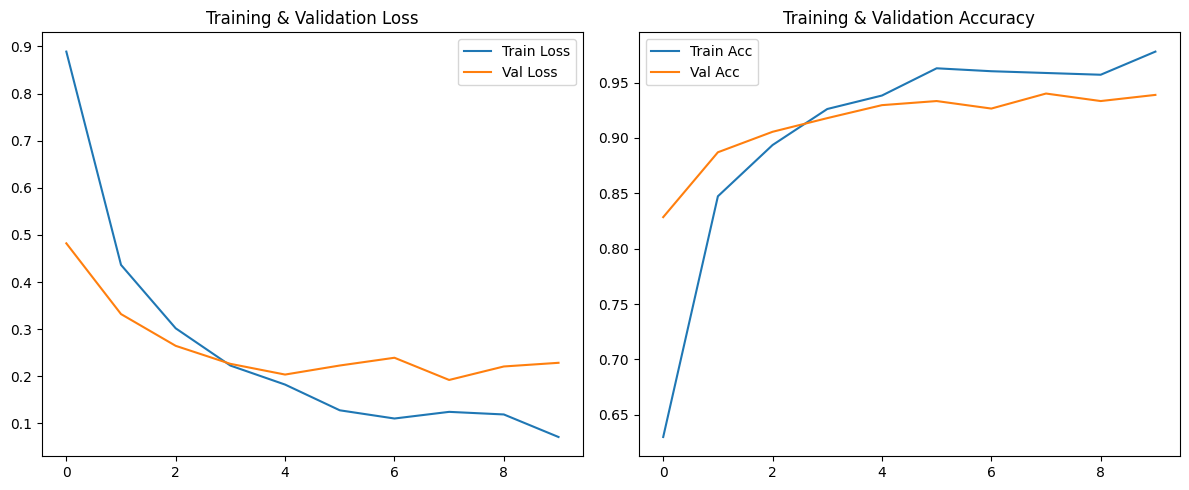


[EfficientNet B0]
  Total Epochs: 10
  Train Loss: 0.2585 | Val Loss: 0.2612
  Train Acc : 0.9780 | Val Acc : 0.9389
  Time : 243.9296s ~ 4.0655m


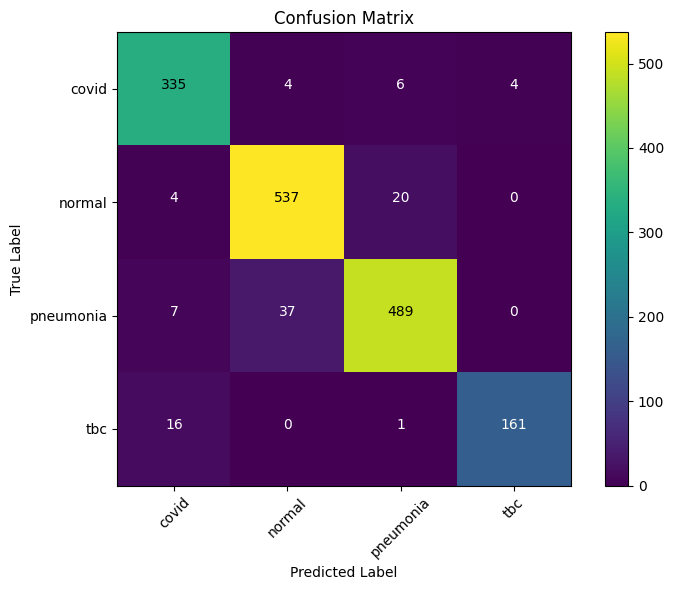

,precision,recall,f1-score,support
covid,0.925414,0.959885,0.942335,349.000000
normal,0.929066,0.957219,0.942932,561.000000
pneumonia,0.947674,0.917448,0.932316,533.000000
tbc,0.975758,0.904494,0.938776,178.000000
accuracy,0.938927,0.938927,0.938927,0.938927
macro avg,0.944478,0.934762,0.939090,1621.000000
weighted avg,0.939525,0.938927,0.938857,1621.000000


In [16]:
pipeline("EfficientNet B0", epochs, model_effNetB0, optimizer_effNetB0, val_loader)

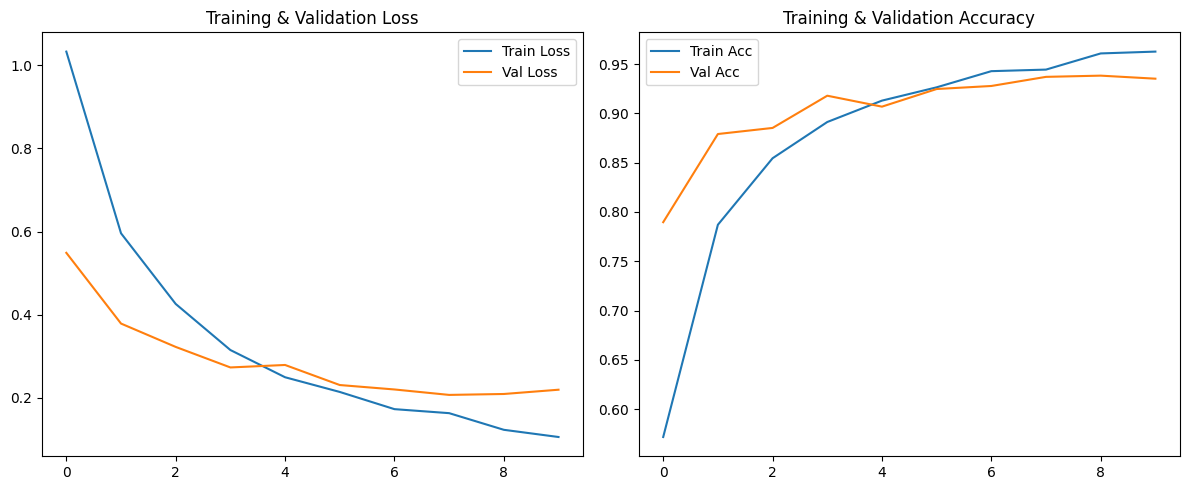


[EfficientNet B1]
  Total Epochs: 10
  Train Loss: 0.3399 | Val Loss: 0.2890
  Train Acc : 0.9627 | Val Acc : 0.9352
  Time : 308.8260s ~ 5.1471m


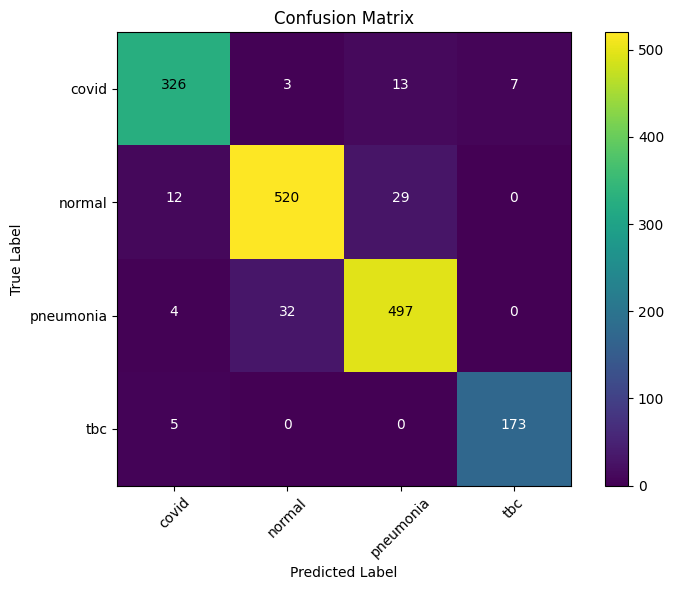

,precision,recall,f1-score,support
covid,0.939481,0.934097,0.936782,349.000000
normal,0.936937,0.926916,0.931900,561.000000
pneumonia,0.922078,0.932458,0.927239,533.000000
tbc,0.961111,0.971910,0.966480,178.000000
accuracy,0.935225,0.935225,0.935225,0.935225
macro avg,0.939902,0.941345,0.940600,1621.000000
weighted avg,0.935253,0.935225,0.935215,1621.000000


In [17]:
pipeline("EfficientNet B1", epochs, model_effNetB1, optimizer_effNetB1, val_loader)

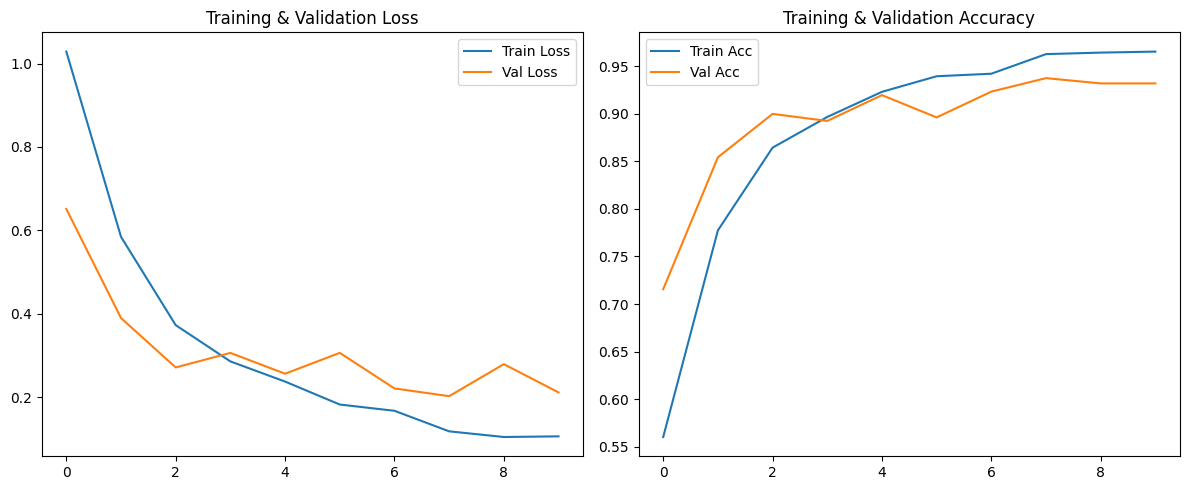


[EfficientNet B2]
  Total Epochs: 10
  Train Loss: 0.3190 | Val Loss: 0.3098
  Train Acc : 0.9656 | Val Acc : 0.9321
  Time : 316.5551s ~ 5.2759m


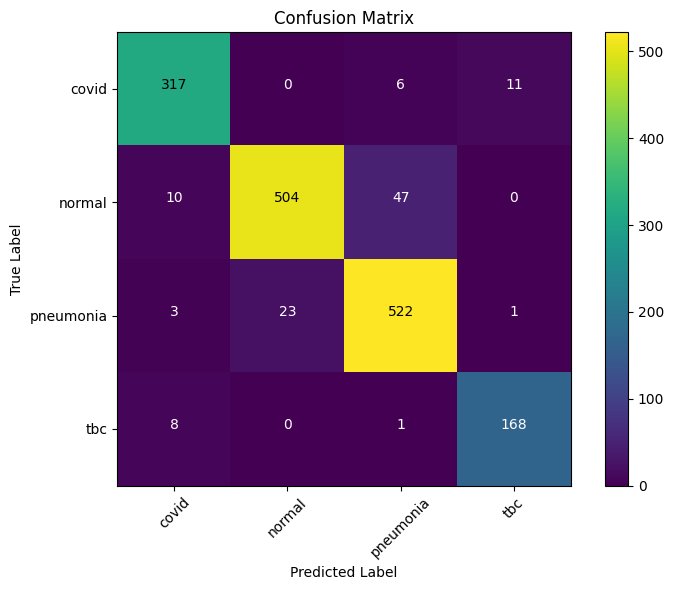

,precision,recall,f1-score,support
covid,0.937870,0.949102,0.943452,334.000000
normal,0.956357,0.898396,0.926471,561.000000
pneumonia,0.906250,0.950820,0.928000,549.000000
tbc,0.933333,0.949153,0.941176,177.000000
accuracy,0.932141,0.932141,0.932141,0.932141
macro avg,0.933452,0.936867,0.934775,1621.000000
weighted avg,0.933063,0.932141,0.932093,1621.000000


In [13]:
pipeline("EfficientNet B2", epochs, model_effNetB2, optimizer_effNetB2, val_loader)

In [ ]:
pipeline("EfficientNet B3", epochs, model_effNetB3, optimizer_effNetB3, val_loader)

In [ ]:
pipeline("EfficientNet B4", epochs, model_effNetB4, optimizer_effNetB4, val_loader)

In [ ]:
pipeline("EfficientNet B5", epochs, model_effNetB5, optimizer_effNetB5, val_loader)

In [ ]:
pipeline("EfficientNet B6", epochs, model_effNetB6, optimizer_effNetB6, val_loader)

In [ ]:
pipeline("EfficientNet B7", epochs, model_effNetB7, optimizer_effNetB7, val_loader)

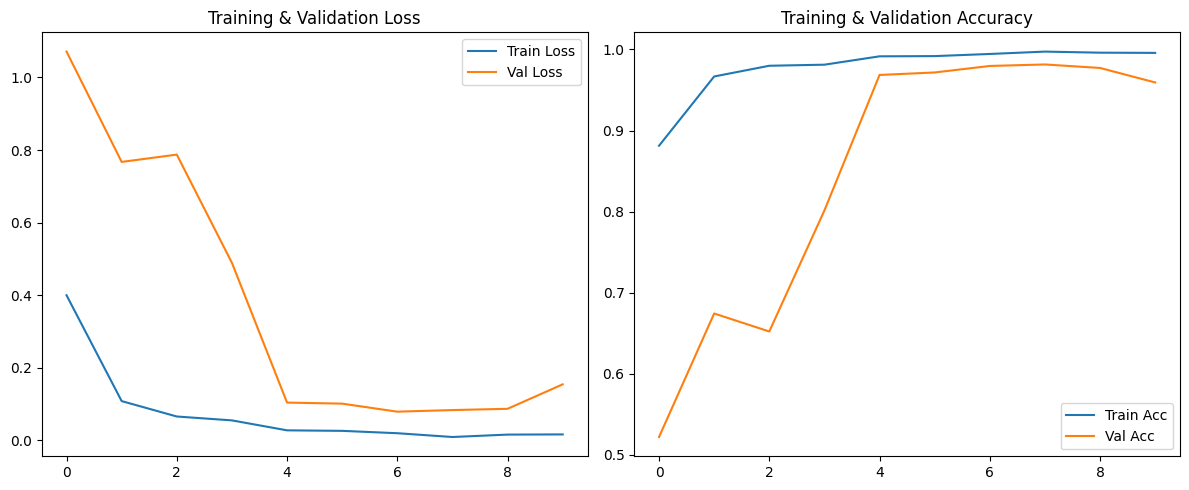


[MobileNetV3-Small Pretrained]
  Total Epochs: 10
  Train Loss: 0.0747 | Val Loss: 0.3726
  Train Acc : 0.9958 | Val Acc : 0.9593
  Time : 170.8650s ~ 2.8478m


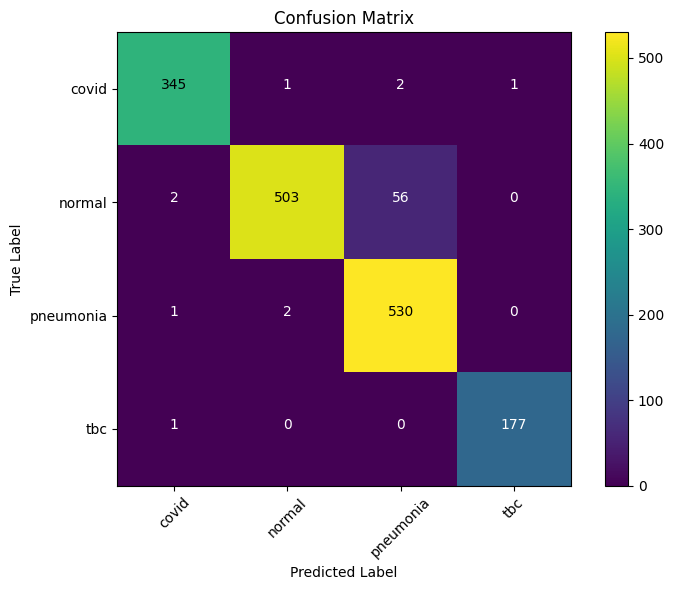

,precision,recall,f1-score,support
covid,0.988539,0.988539,0.988539,349.000000
normal,0.994071,0.896613,0.942830,561.000000
pneumonia,0.901361,0.994371,0.945584,533.000000
tbc,0.994382,0.994382,0.994382,178.000000
accuracy,0.959284,0.959284,0.959284,0.959284
macro avg,0.969588,0.968476,0.967834,1621.000000
weighted avg,0.962430,0.959284,0.959238,1621.000000


In [12]:
pipeline("MobileNetV3-Small Pretrained", epochs, model_mobnetv3_small_pre, optimizer_mobnetv3_small_pre, val_loader)

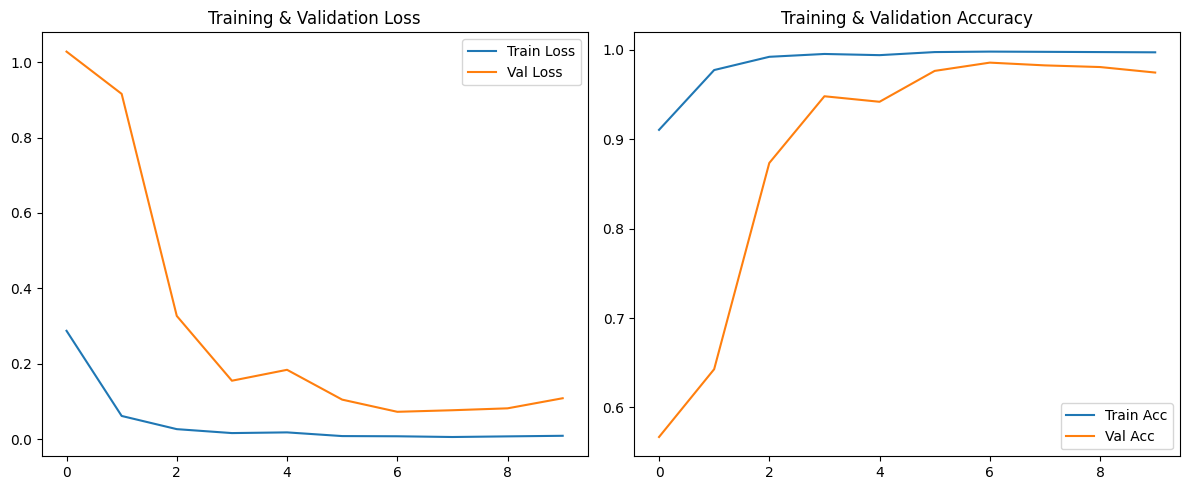


[MobileNetV3-Large Pretrained]
  Total Epochs: 10
  Train Loss: 0.0447 | Val Loss: 0.3054
  Train Acc : 0.9974 | Val Acc : 0.9747
  Time : 185.0412s ~ 3.0840m


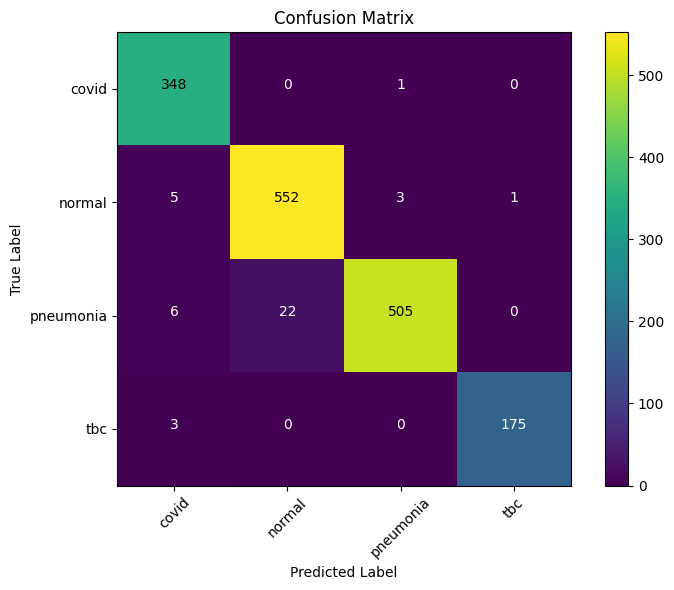

,precision,recall,f1-score,support
covid,0.961326,0.997135,0.978903,349.000000
normal,0.961672,0.983957,0.972687,561.000000
pneumonia,0.992141,0.947467,0.969290,533.000000
tbc,0.994318,0.983146,0.988701,178.000000
accuracy,0.974707,0.974707,0.974707,0.974707
macro avg,0.977365,0.977926,0.977395,1621.000000
weighted avg,0.975201,0.974707,0.974667,1621.000000


In [13]:
pipeline("MobileNetV3-Large Pretrained", epochs, model_mobnetv3_large_pre, optimizer_mobnetv3_large_pre, val_loader)

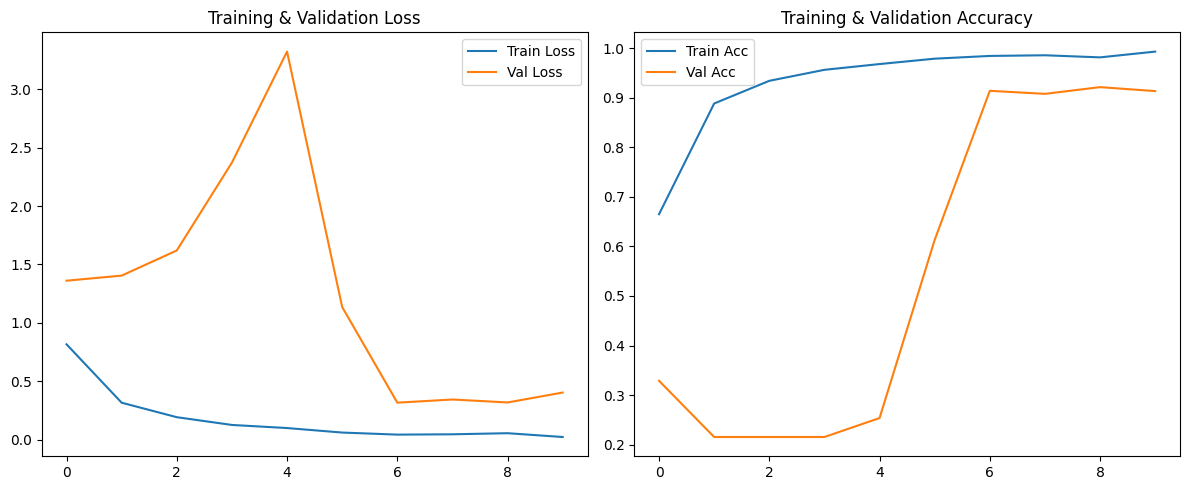


[MobileNetV3-Small]
  Total Epochs: 10
  Train Loss: 0.1792 | Val Loss: 1.2601
  Train Acc : 0.9934 | Val Acc : 0.9136
  Time : 163.6195s ~ 2.7270m


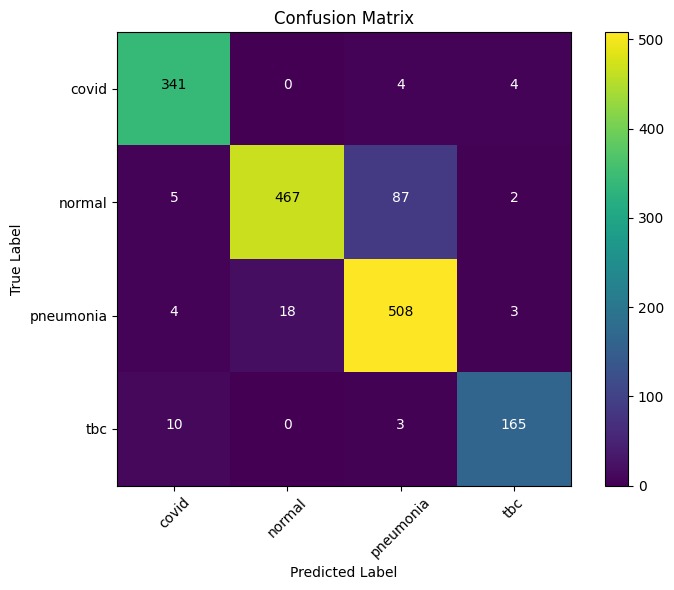

,precision,recall,f1-score,support
covid,0.947222,0.977077,0.961918,349.000000
normal,0.962887,0.832442,0.892925,561.000000
pneumonia,0.843854,0.953096,0.895154,533.000000
tbc,0.948276,0.926966,0.937500,178.000000
accuracy,0.913634,0.913634,0.913634,0.913634
macro avg,0.925560,0.922395,0.921874,1621.000000
weighted avg,0.918771,0.913634,0.913407,1621.000000


In [14]:
pipeline("MobileNetV3-Small", epochs, model_mobnetv3_small, optimizer_mobnetv3_small, val_loader)

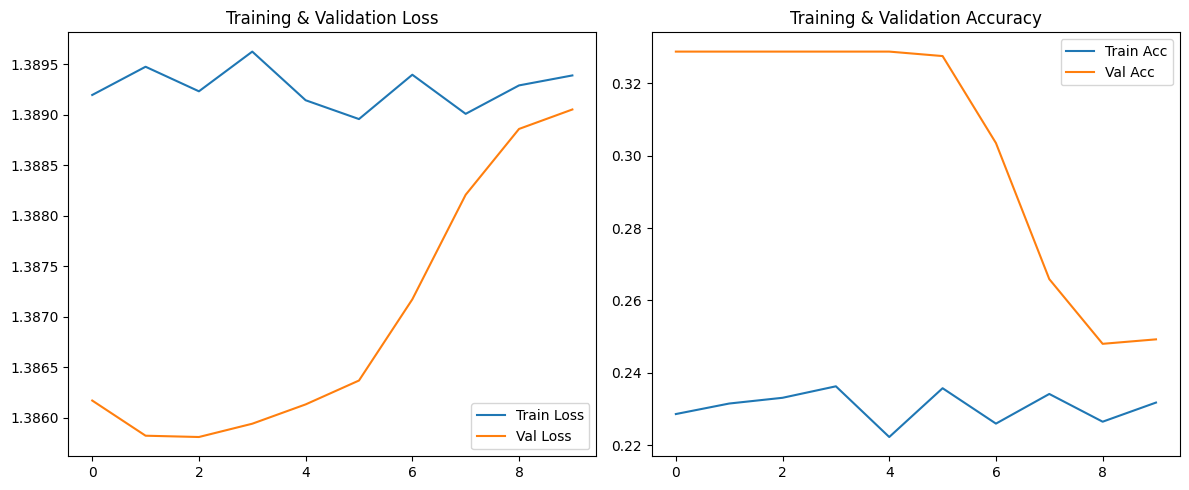


[MobileNetV3-Large]
  Total Epochs: 10
  Train Loss: 1.3893 | Val Loss: 1.3870
  Train Acc : 0.2317 | Val Acc : 0.2492
  Time : 186.3289s ~ 3.1055m


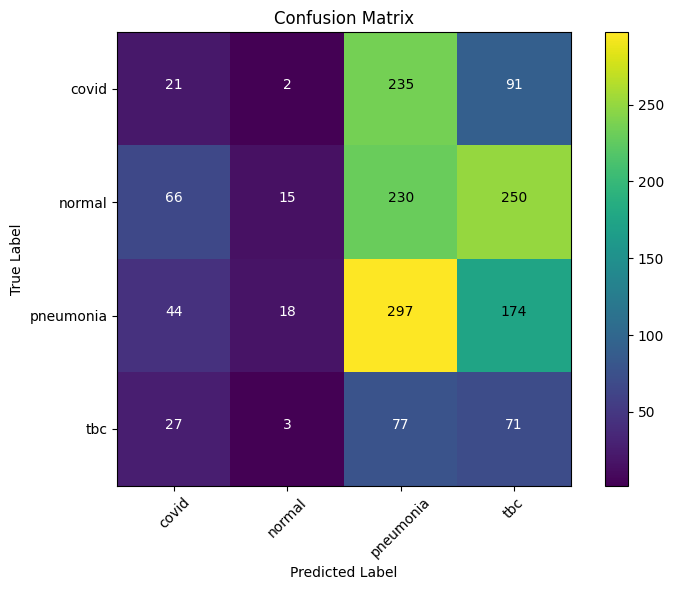

,precision,recall,f1-score,support
covid,0.132911,0.060172,0.082840,349.000000
normal,0.394737,0.026738,0.050083,561.000000
pneumonia,0.353993,0.557223,0.432945,533.000000
tbc,0.121160,0.398876,0.185864,178.000000
accuracy,0.249229,0.249229,0.249229,0.249229
macro avg,0.250700,0.260752,0.187933,1621.000000
weighted avg,0.294928,0.249229,0.197934,1621.000000


In [15]:
pipeline("MobileNetV3-Large", epochs, model_mobnetv3_large, optimizer_mobnetv3_large, val_loader)

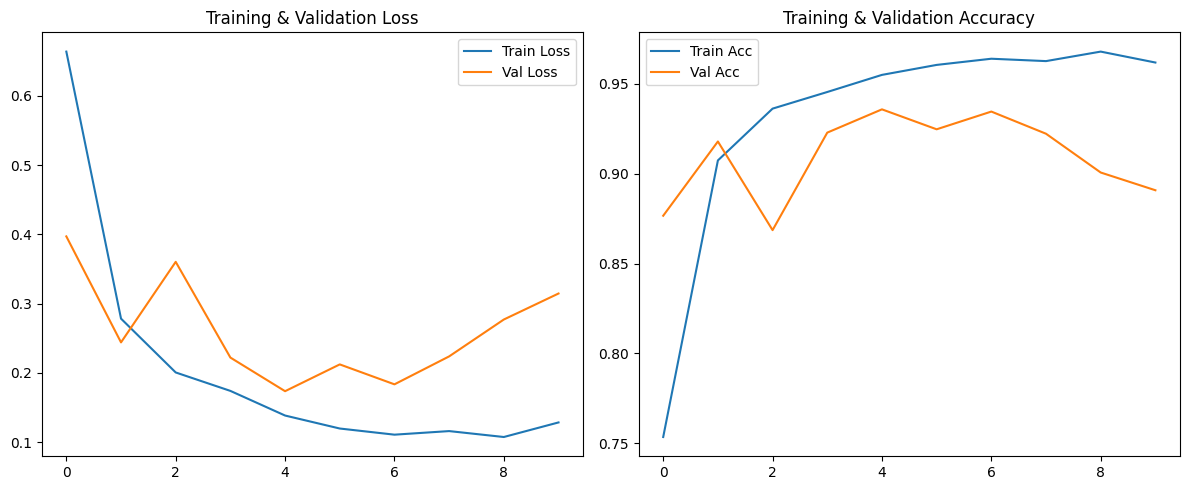


[Efficient-ResNet Net Pretrained]
  Total Epochs: 10
  Train Loss: 0.2036 | Val Loss: 0.2607
  Train Acc : 0.9619 | Val Acc : 0.8908
  Time : 478.4663s ~ 7.9744m


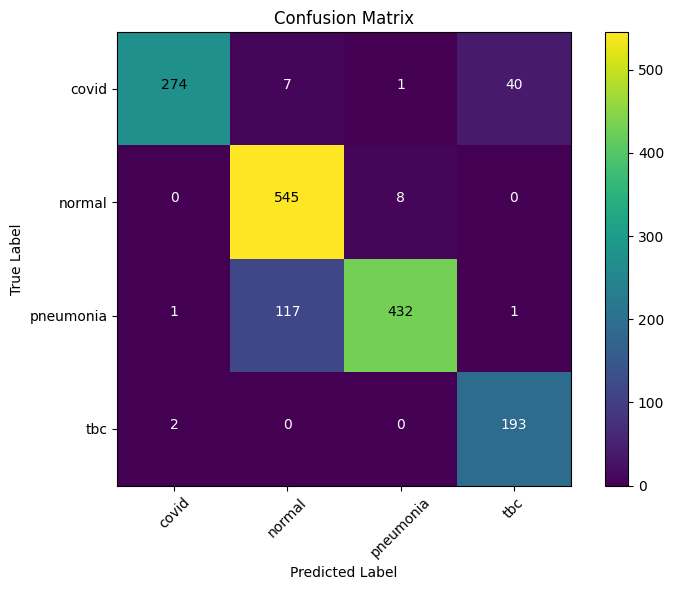

,precision,recall,f1-score,support
covid,0.989170,0.850932,0.914858,322.000000
normal,0.814649,0.985533,0.891980,553.000000
pneumonia,0.979592,0.784029,0.870968,551.000000
tbc,0.824786,0.989744,0.899767,195.000000
accuracy,0.890808,0.890808,0.890808,0.890808
macro avg,0.902049,0.902559,0.894393,1621.000000
weighted avg,0.906602,0.890808,0.890319,1621.000000


In [15]:
pipeline("Efficient-ResNet Pretrained", model_hybrideffnet, optimizer_hybrideffnet, val_loader, epochs=10, scheduler=True)

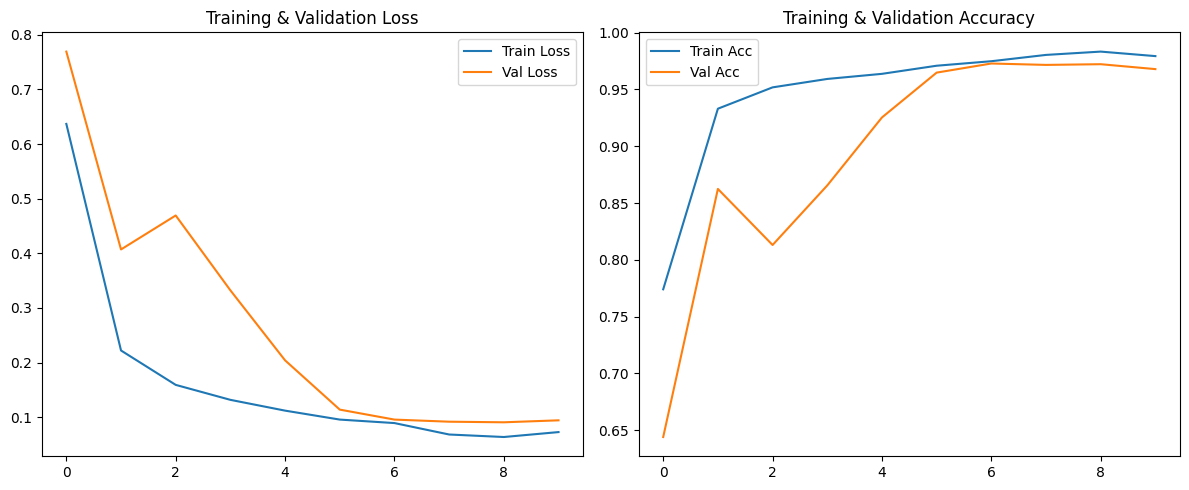


[Mobile-ResNet Pretrained]
  Total Epochs: 10
  Train Loss: 0.1651 | Val Loss: 0.2668
  Train Acc : 0.9794 | Val Acc : 0.9679
  Time : 473.0116s ~ 7.8835m


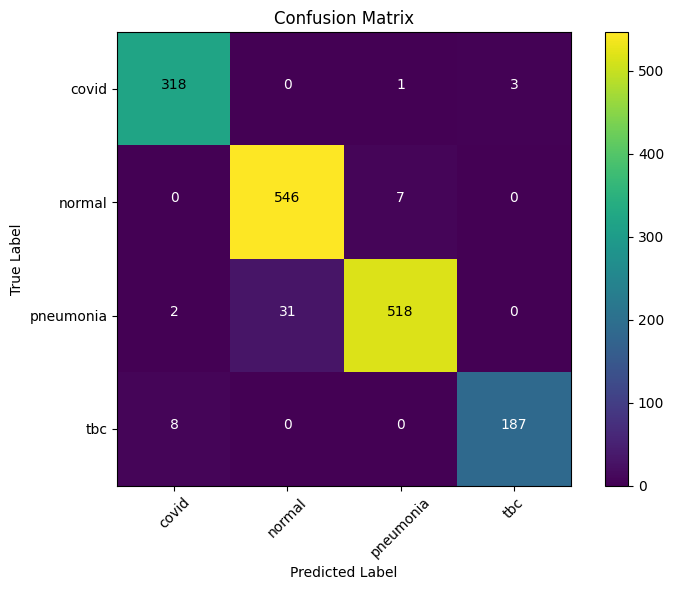

,precision,recall,f1-score,support
covid,0.969512,0.987578,0.978462,322.000000
normal,0.946274,0.987342,0.966372,553.000000
pneumonia,0.984791,0.940109,0.961931,551.000000
tbc,0.984211,0.958974,0.971429,195.000000
accuracy,0.967921,0.967921,0.967921,0.967921
macro avg,0.971197,0.968501,0.969548,1621.000000
weighted avg,0.968546,0.967921,0.967872,1621.000000


In [16]:
pipeline("Mobile-ResNet Pretrained", model_hybridmobnet, optimizer_hybridmobnet, val_loader, epochs=10, scheduler=True)

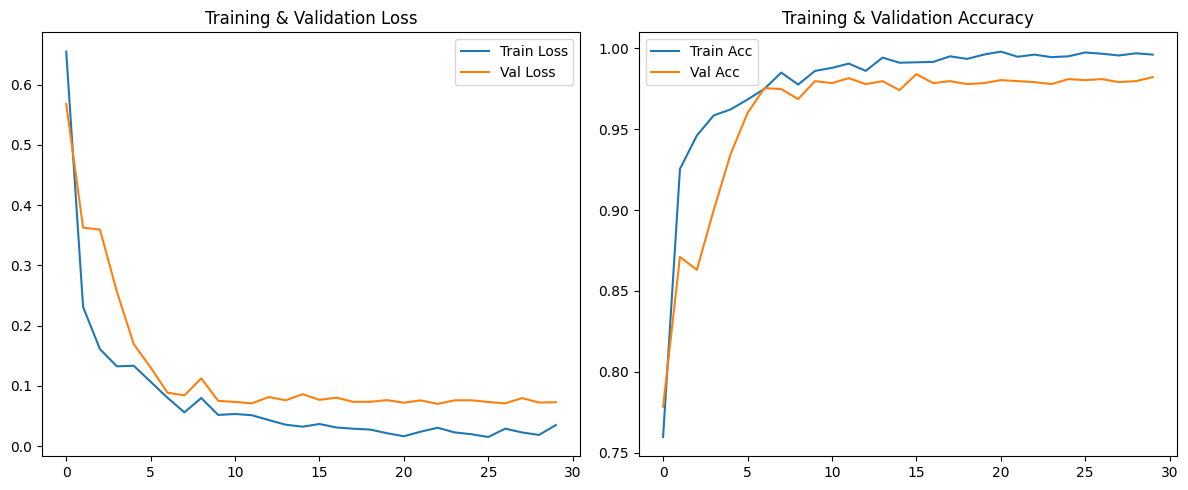


[Hybrid Mobile Net Pretrained]
  Total Epochs: 30
  Train Loss: 0.0761 | Val Loss: 0.1239
  Train Acc : 0.9960 | Val Acc : 0.9821
  Time : 1405.0662s ~ 23.4178m


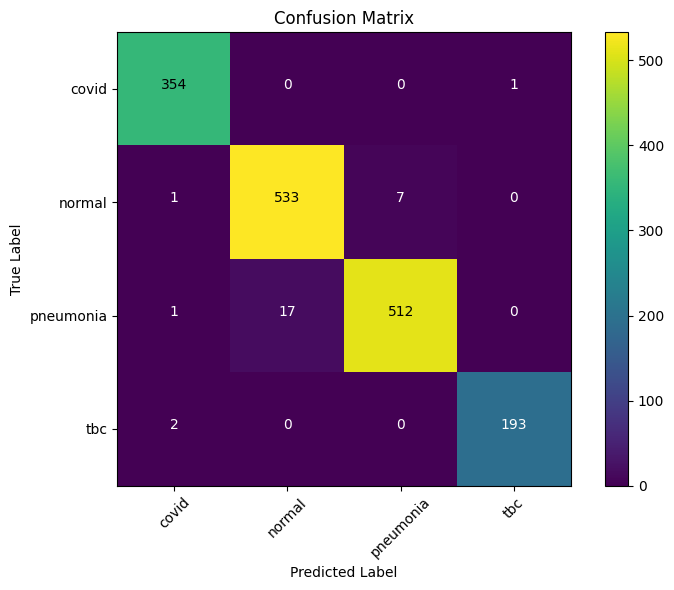

,precision,recall,f1-score,support
covid,0.988827,0.997183,0.992987,355.00000
normal,0.969091,0.985213,0.977085,541.00000
pneumonia,0.986513,0.966038,0.976168,530.00000
tbc,0.994845,0.989744,0.992288,195.00000
accuracy,0.982110,0.982110,0.982110,0.98211
macro avg,0.984819,0.984544,0.984632,1621.00000
weighted avg,0.982207,0.982110,0.982097,1621.00000


In [83]:
pipeline("Hybrid Mobile Net Pretrained", model_hybridmobnet, optimizer_hybridmobnet, val_loader, epochs=30, scheduler=True)

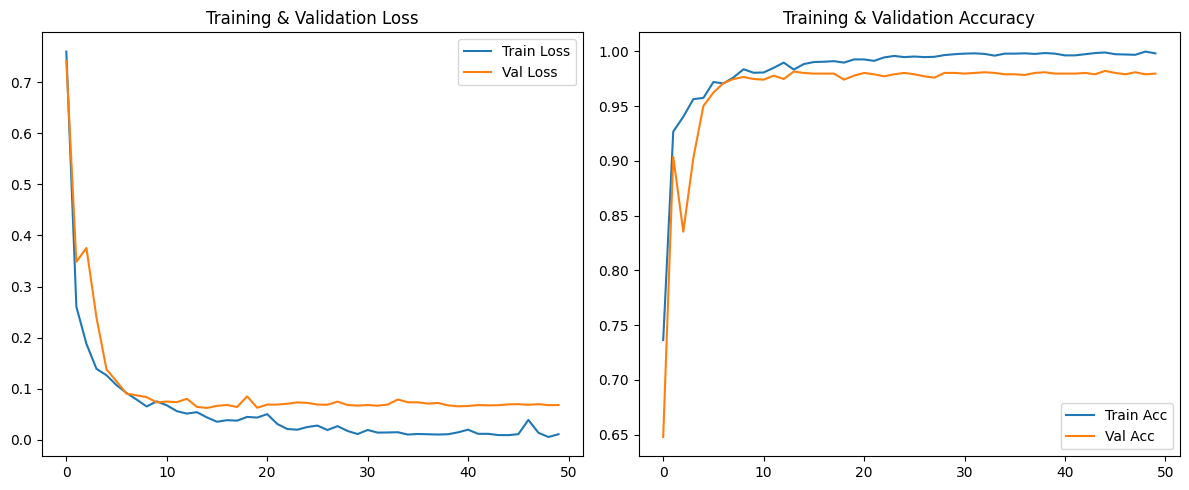


[Hybrid Mobile Net Pretrained]
  Total Epochs: 50
  Train Loss: 0.0578 | Val Loss: 0.1018
  Train Acc : 0.9981 | Val Acc : 0.9796
  Time : 2264.7952s ~ 37.7466m


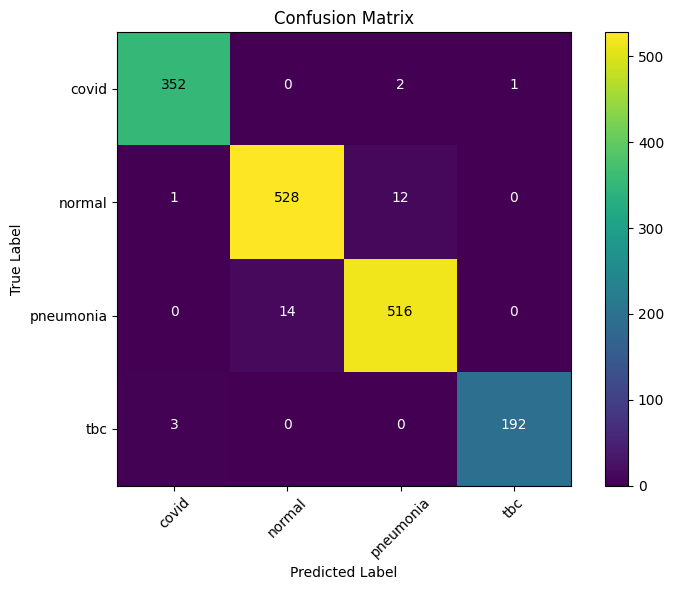

,precision,recall,f1-score,support
covid,0.988764,0.991549,0.990155,355.000000
normal,0.974170,0.975970,0.975069,541.000000
pneumonia,0.973585,0.973585,0.973585,530.000000
tbc,0.994819,0.984615,0.989691,195.000000
accuracy,0.979642,0.979642,0.979642,0.979642
macro avg,0.982834,0.981430,0.982125,1621.000000
weighted avg,0.979659,0.979642,0.979647,1621.000000


In [76]:
pipeline("Hybrid Mobile Net Pretrained", model_hybridmobnet, optimizer_hybridmobnet, val_loader, epochs=10, scheduler=True)

In [16]:
#model_vgg16.parameters()
model_parameters = filter(lambda p: p.requires_grad, model_mobnetv3_small_pre.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

In [17]:
params

1521956